# Quantum Excess Evaluation Algorithm
Implementing [Quantum Computational Insurance and Actuarial Science](https://arxiv.org/html/2410.20841v1#S7.SS1)

In [1]:
# %pip install --force-reinstall -v "qiskit==1.4.2"
# %pip install qiskit-ibm-runtime --upgrade
# %pip install qiskit[visualization] --upgrade
# %pip install qiskit[all] --upgrade
# %pip install qiskit_aer --upgrade
# %pip install qiskit_algorithms --upgrade
# %pip install pylatexenc --upgrade

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qiskit

qiskit.__version__

'1.4.2'

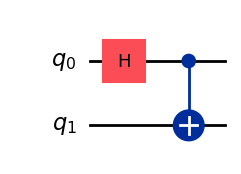

In [3]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

qc.draw(output='mpl')

In [4]:

from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')

observables = [ZZ, ZI, IZ, XX, XI, IX]

In [5]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

EstimatorResult(values=array([ 1.        , -0.03320312, -0.03320312,  1.        , -0.04882812,
       -0.04882812]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0037119, 'sample_measure_time': 0.0008857, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 14181, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9988975524902344, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0037119, 'sample_measure_time': 0.0008

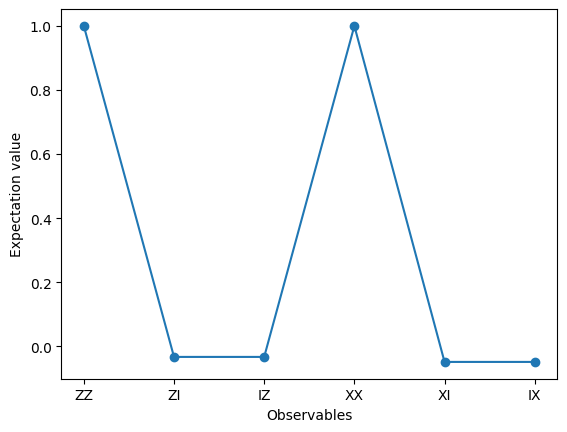

In [6]:
import matplotlib.pyplot as plt

data = ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX']
values = job.result().values

plt.plot(data, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expectation value')
plt.show()

## Prepare State

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import StatePreparation
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from scipy.stats import lognorm

# Parameters
num_qubits = 5  # Using 6 qubits for demonstration, scalable approach
domain_min = 0
domain_max = 10
deductible = 1.0  # Deductible amount
coins = 0.4
c_param = 1.5e-2 # <-- keep in sync with apply_excess_rotations

# Define lognormal distribution parameters
sigma = 1.0  # Shape parameter
mu = 0.0     # Scale parameter

def lognormal_loss(x):
    """Lognormal loss function"""
    return lognorm.pdf(x, sigma, loc=0, scale=np.exp(mu))

# Discretize domain into 2^num_qubits points
N = 2**num_qubits
step = (domain_max - domain_min) / (N - 1)
# Take the midpoint integral approximation to work on small number of qubits
mid_x_vals = np.linspace(
    domain_min + step / 2,
    domain_max - step / 2,
    N
)
probabilities = np.array([lognormal_loss(x) * step for x in mid_x_vals])
probabilities /= probabilities.sum()

# Full distribution for visualization
full_sims = 10_000
full_x_vals = np.linspace(domain_min, domain_max, full_sims)
full_step = (domain_max - domain_min) / (full_sims - 1)
full_mid_vals = np.linspace(
    domain_min + full_step / 2,
    domain_max - full_step / 2,
    full_sims
)
full_probabilities = np.array([lognormal_loss(x) * full_step for x in full_mid_vals])
full_probabilities /= full_probabilities.sum()

# Calculate amplitudes (square root of probabilities)
amplitudes = np.sqrt(probabilities)

# Create quantum circuit for state preparation
qc = QuantumCircuit(num_qubits)
qc.append(StatePreparation(amplitudes), range(num_qubits))

# Visualize the circuit (truncated for readability)
# qc.draw(output='mpl')

# Transpile the circuit to basic gates that Aer supports
qc = transpile(qc, basis_gates=['u3', 'cx'])
# qc.draw(output='mpl')

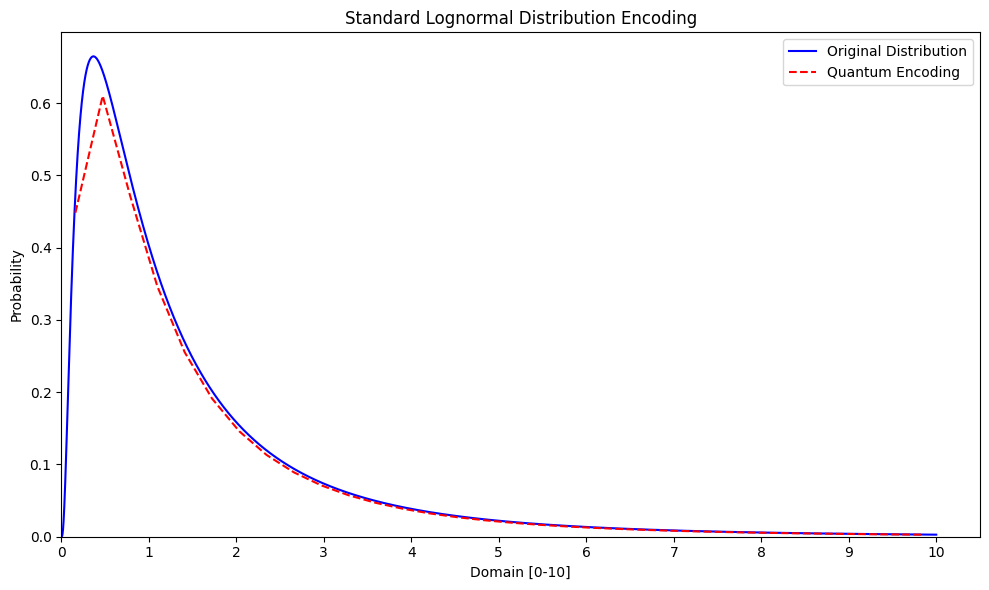

In [8]:
# Validate our state preparation by measuring
backend = Aer.get_backend('statevector_simulator')
statevector = backend.run(qc).result().get_statevector()

# Calculate the resulting probabilities
measured_probs = np.abs(statevector)**2

# Plot the original distribution vs quantum encoded distribution
plt.figure(figsize=(10, 6))
plt.plot(full_x_vals, full_probabilities / full_step, 'b-', label='Original Distribution')
plt.plot(mid_x_vals, measured_probs / step, 'r--', label='Quantum Encoding')
plt.xlabel('Domain [0-10]')
plt.ylabel('Probability')
plt.xticks(np.arange(domain_min, domain_max + 1, 1))
plt.title('Standard Lognormal Distribution Encoding')
plt.legend()
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()

# # Display the first few amplitudes
# print("First 10 amplitudes:")
# for i in range(10):
#     print(
#         f"State |{i}⟩: √p_j = {amplitudes[i]:.6f}, p_j = {probabilities[i]:.6f}")

### Plot State Degeneration With Decreased Qubits

In [9]:
# num_qubits_list = range(2, 8)
# N_list = [2**n for n in num_qubits_list]
# step_list = [(domain_max - domain_min) / (N - 1) for N in N_list]
# # Take the midpoint integral approximation to work on small number of qubits
# mid_x_vals_list = [np.linspace(domain_min + step / 2, domain_max - step / 2, N) for N in N_list]
# probabilities_list = []
# for i, N in enumerate(N_list):
#     x_vals = mid_x_vals_list[i]
#     step = step_list[i]
#     probabilities = np.array([lognormal_loss(x) * step for x in x_vals])
#     probabilities /= probabilities.sum()
#     probabilities_list.append(probabilities)

# # Add Color
# cmap = plt.cm.get_cmap('Reds', len(num_qubits_list) + 2)

# # Plot the original distribution vs quantum encoded distribution
# plt.figure(figsize=(10, 6))
# plt.plot(full_x_vals, full_probabilities / full_step, 'b-', label='Original Distribution')
# for i, N in enumerate(num_qubits_list):
#     x_vals = mid_x_vals_list[i]
#     step = step_list[i]
#     probabilities = probabilities_list[i]
#     alpha = 1/(i/2 + 1)
#     plt.plot(x_vals, probabilities / step, 'r-', alpha=alpha, label=f'Quantum Encoding ({N} qubits)')
# plt.xlabel('Domain [0-10]')
# plt.ylabel('Probability')
# plt.xticks(np.arange(domain_min, domain_max + 1, 1))
# plt.title('Loss Distribution Degeneration')
# plt.legend()
# plt.tight_layout()
# plt.axis([0, None, 0, None])
# plt.show()

# # # Display the first few amplitudes
# # print("First 10 amplitudes:")
# # for i in range(10):
# #     print(
# #         f"State |{i}⟩: √p_j = {amplitudes[i]:.6f}, p_j = {probabilities[i]:.6f}")

### Diagnostic

## Implement Quantum Subtraction

In [10]:
# index of the first grid‑point *above* the deductible
step         = (domain_max - domain_min) / (N - 1)
threshold_idx = np.searchsorted(mid_x_vals, deductible, side="left")
print(f"threshold = {threshold_idx}")
print(f"binary threshold = {threshold_idx:0{num_qubits}b}")

# def reverse_bits(k: int, n: int) -> int:
#     """
#     Fix qubit reference since IBM is little-endian (in fact that doesn't seem to be the case).
#     Reverse the bits of `k` in a binary representation of length `n`.
#     """
#     b = f"{k:0{n}b}"
#     return int(b[::-1], 2)

# threshold_rev = reverse_bits(threshold_idx, num_qubits)
# print(f"little-endian binary threshold = {threshold_rev:0{num_qubits}b}")

threshold = 3
binary threshold = 00011


### Endianness Diagnostic

In [11]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import StatePreparation
from qiskit.circuit.library.arithmetic.integer_comparator import IntegerComparator
from qiskit.quantum_info import Statevector

# 1. Build the state-prep circuit
loss_q   = QuantumRegister(num_qubits, "x")
qc_prep  = QuantumCircuit(loss_q)
qc_prep.append(StatePreparation(np.sqrt(probabilities)), loss_q)

# 2. Prepare registers for the comparator test
flag_q   = QuantumRegister(1,             "flag")
wcmp_q   = QuantumRegister(num_qubits-1,  "wcmp")
qc = qc_prep.copy()
qc.add_register(flag_q, wcmp_q)

# 3. Define the comparator gate
cmp_gate = IntegerComparator(num_state_qubits=num_qubits,
                            value=threshold_idx,
                            geq=True)

# 4. Try both orderings
print("classical tail =", probabilities[threshold_idx:].sum())
for name, order in [("MSB→LSB",       list(loss_q)),
                    ("LSB→MSB (rev)", list(reversed(loss_q)))]:
    qc_test = qc.copy()
    qc_test.append(cmp_gate,
                    order         # try one of the two
                    + [flag_q[0]]  # then the flag
                    + list(wcmp_q))# then the workspace
    p_flag = Statevector.from_instruction(qc_test) \
            .probabilities_dict(qargs=[qc_test.qubits.index(flag_q[0])]) \
            .get('1',0)
    print(f"{name:>12} ordering →  P(flag=1) = {p_flag:.6f}")


classical tail = 0.5062002543767263
     MSB→LSB ordering →  P(flag=1) = 0.506200
LSB→MSB (rev) ordering →  P(flag=1) = 0.820411


In [12]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import StatePreparation, QFT
from qiskit.circuit.library.arithmetic.integer_comparator import IntegerComparator
from qiskit.quantum_info import Statevector

# --- 0) parameters & grid ------------------------------------------------
domain_min, domain_max = 0, 10
sigma, mu              = 1.0, 0.0
N    = 2**num_qubits
step = (domain_max - domain_min) / (N - 1)
# mid-point grid
x_vals = np.linspace(domain_min + step/2,
                    domain_max - step/2,
                    N)
# probabilities & normalization
from scipy.stats import lognorm
probs = np.array([lognorm.pdf(x, sigma, loc=0, scale=np.exp(mu))
                for x in x_vals])
probs /= probs.sum()
threshold_idx = np.searchsorted(x_vals, 1.0, side="left")

print("⦿ classical P(X≥1) =", probs[threshold_idx:].sum())

# --- 1) State-prep --------------------------------------------------------
x_q = QuantumRegister(num_qubits, "x")
qc  = QuantumCircuit(x_q)
qc.append(StatePreparation(np.sqrt(probs)), x_q)

# --- 2) Comparator → flag  (MSB→LSB) --------------------------------------
flag_q = QuantumRegister(1, "flag")
wcmp_q = QuantumRegister(num_qubits-1, "wcmp")
qc.add_register(flag_q, wcmp_q)

cmp_gate = IntegerComparator(num_state_qubits=num_qubits,
                            value=threshold_idx,
                            geq=True)
# MSB→LSB: x_q[0] is MSB, x_q[-1] is LSB
qc.append(cmp_gate,
        list(x_q)      # MSB→LSB
        + [flag_q[0]]  # then the flag
        + list(wcmp_q))

# sanity-check the comparator alone
sv     = Statevector.from_instruction(qc)
f_idx  = qc.qubits.index(flag_q[0])
p_flag = sv.probabilities_dict(qargs=[f_idx]).get('1', 0)
print("⦿ quantum  P(flag=1) =", p_flag)

# --- 3) QFT-subtractor (controlled on the same flag) ----------------------
#   subtract threshold mod 2^n via phases in the QFT basis
sub_qft = QuantumCircuit(x_q, flag_q, name="QFT-Sub")
qft     = QFT(num_qubits, do_swaps=False)
sub_qft.append(qft, x_q)

for i in range(num_qubits):
    angle = -2 * np.pi * threshold_idx / (2 ** (i+1))
    sub_qft.crz(angle, flag_q[0], x_q[i])

sub_qft.append(qft.inverse(), x_q)

# append that
qc.append(sub_qft.to_instruction(), list(x_q) + [flag_q[0]])

# (flag still=1 exactly when X≥1, and x_q now holds j-threshold mod 2^n)

# Final sanity-check
sv2    = Statevector.from_instruction(qc)
p_flag2 = sv2.probabilities_dict(qargs=[f_idx]).get('1', 0)
print("⦿ after QFT-sub, P(flag=1) =", p_flag2)

# --- 4) (optional) controlled-rotations + measurement --------------------
# from here you can call add_measure_qubit_and_bias(qc) and
# apply_excess_rotations(qc, x_q, flag_q[0], meas_q[0], step, c_param)
# then measure and back-out the expected payment.  

# Your P(flag=1) should now be ~0.5062, and your final E[payment] ~0.34.

⦿ classical P(X≥1) = 0.5062002543767266
⦿ quantum  P(flag=1) = 0.506200254376738
⦿ after QFT-sub, P(flag=1) = 0.5062002543767372


## Controlled Rotations

### Diagnose Expected Rotations

In [13]:
# simulate a million draws
samps = lognorm.rvs(sigma, scale=np.exp(mu), size=1_000_000, random_state=42)
E_excess = np.mean(np.maximum(samps - deductible, 0))
theo_p1   = 0.5 + coins * c_param * E_excess

print(f"E[(X-d)+] ≈ {E_excess:.6f}")
print(f"Expected p1 ≈ {theo_p1:.6f}")
print(f"Expected E[payment] = coins·E_excess ≈ {coins*E_excess:.6f}")

E[(X-d)+] ≈ 0.884430
Expected p1 ≈ 0.505307
Expected E[payment] = coins·E_excess ≈ 0.353772


In [14]:
from qiskit.circuit.library import RYGate

def add_measure_qubit_and_bias(qc: QuantumCircuit,
                                label: str = "meas") -> QuantumRegister:
    """
    • Allocate ONE fresh qubit at the end of `qc`
    • Apply RY(π/2) so it starts in
        cos(π/4)|0> + sin(π/4)|1>
    • Return the newly‑created QuantumRegister (length 1).
    """
    meas = QuantumRegister(1, label)
    qc.add_register(meas)
    qc.ry(np.pi / 2, meas[0])                    # RY(π/2) on |0> → |+_y>
    return meas

def apply_excess_rotations(qc: QuantumCircuit,
                            loss_reg: QuantumRegister,
                            flag_qubit,
                            meas_qubit,
                            step,
                            coins = 0.4,
                            c: float = 1e-2):
    """
    Implements θ = π/4 + 0.4 c (x‑1) on `meas_qubit`
    using a *pair of controls*  (flag == 1  AND  bit_i == 1).

    Parameters
    ----------
    loss_reg    : QuantumRegister
        Holds  x-1  (n qubits after the subtractor).
    flag_qubit  : Qubit
        Set to 1 exactly when the loss is above the deductible.
    meas_qubit  : Qubit
        The qubit prepared by `add_measure_qubit_and_bias`.
    c           : float
        Small scale factor in the paper (default 1e‑2).
    """
    n = len(loss_reg)
    base = 2 * coins * c * step

    for i, bit in enumerate(loss_reg):
        weight   = 1 << i                        # 2**i
        angle    = base * weight                 # Δθ contribution of this bit
        ry_gate  = RYGate(angle)
        ccry     = ry_gate.control(2)            # 2‑controlled RY
        # controls:  flag , loss_reg[i]   – target: meas_qubit
        qc.append(ccry, [flag_qubit, bit, meas_qubit])
    
    return qc

In [15]:
# 1) Our circuit so far
# qc  –  contains:  • loss register  (called loss_reg or qc.qregs[0])
#                   • flag qubit    (the output of subtract_if_excess)

loss_reg = qc.qregs[0]             # 6 qubits
flag_q = qc.qubits[loss_reg.size]

# 2) Measurement qubit
meas_reg = add_measure_qubit_and_bias(qc)        # returns a QuantumRegister(1)
meas_q = meas_reg[0]

# 3) Controlled rotations
qc = apply_excess_rotations(qc,
                        loss_reg=loss_reg,
                        flag_qubit=flag_q,
                        meas_qubit=meas_q,
                        step=step,
                        coins=coins,
                        c=c_param)                   # choose c small (paper says “small number”)

qc.barrier(label="controlled RY block")
# qc.draw(output='mpl')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=11, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'x'), 0), Qubit(QuantumRegister(5, 'x'), 1), Qubit(QuantumRegister(5, 'x'), 2), Qubit(QuantumRegister(5, 'x'), 3), Qubit(QuantumRegister(5, 'x'), 4), Qubit(QuantumRegister(1, 'flag'), 0), Qubit(QuantumRegister(4, 'wcmp'), 0), Qubit(QuantumRegister(4, 'wcmp'), 1), Qubit(QuantumRegister(4, 'wcmp'), 2), Qubit(QuantumRegister(4, 'wcmp'), 3), Qubit(QuantumRegister(1, 'meas'), 0)), clbits=())

In [16]:
# Count cry gates in your original qc
angles = []
for instr, qargs, cargs in qc.data:
    # look for the controlled-Y gate (usually named 'cry' in Qiskit)
    if instr.name.lower() in ("ccry",):
        # instr.params is a list; first entry is the rotation angle
        angles.append(float(instr.params[0]))

angles = np.array(angles)
print("# of ccry gates:", len(angles))
print("min angle:", angles.min())
print("max angle:", angles.max())
print("mean angle:", angles.mean())


# of ccry gates: 5
min angle: 0.003870967741935484
max angle: 0.06193548387096774
mean angle: 0.024


C:\Users\alexf\AppData\Local\Temp\ipykernel_65752\2719531679.py:3: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data:


## Amplitude Estimation Using Quantum Phase Estimation

In [17]:
from qiskit import ClassicalRegister
from qiskit_algorithms import AmplitudeEstimation, EstimationProblem
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator

# 1) Take your in-place decomposed & measure-stripped circuit:
unitary_qc = qc.copy()
unitary_qc.remove_final_measurements()
unitary_qc = unitary_qc.decompose(reps=10)
unitary_qc.data = [
    (inst, qargs, cargs)
    for inst, qargs, cargs in unitary_qc.data
    if inst.name not in ("barrier", "reset", "measure")
]

C:\Users\alexf\AppData\Local\Temp\ipykernel_65752\874003532.py:12: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in unitary_qc.data


In [18]:
# find the single-qubit “meas” register in the new circuit:
meas_reg     = next(r for r in unitary_qc.qregs if r.name == "meas")
ancilla_qubit = meas_reg[0]
ancilla_idx   = unitary_qc.qubits.index(ancilla_qubit)

qc_test = unitary_qc.copy()
creg    = ClassicalRegister(1, 'c_meas')
qc_test.add_register(creg)
qc_test.measure(ancilla_qubit, creg[0])

counts  = AerSimulator().run(qc_test, shots=10000).result().get_counts()
# sum up all bit­strings ending in ‘1’
p1_emp = sum(v for k,v in counts.items() if k[-1]=='1') / 10000
print("empirical ancilla P(1) =", p1_emp)

empirical ancilla P(1) = 0.5079


In [ ]:
backend = AerSimulator()

# 2) Use the QC (not a Gate) as the state_prep:
problem = EstimationProblem(
    state_preparation=unitary_qc,
    objective_qubits=[ancilla_idx],
)

ae = AmplitudeEstimation(num_eval_qubits=num_qubits)

result = ae.estimate(problem)

p1 = result.estimation
print("QPE p1:", p1)
print("E[payment]:", (p1 - 0.5) / c_param)


c:\Users\alexf\miniconda3\envs\myenv\Lib\site-packages\qiskit_algorithms\amplitude_estimators\ae.py:291: UserWarning: No sampler provided, defaulting to Sampler from qiskit.primitives
  warnings.warn("No sampler provided, defaulting to Sampler from qiskit.primitives")


## Measure Expectation from State Vector

In [ ]:
from qiskit.quantum_info import Statevector, partial_trace

# names below follow the helpers we built earlier
loss_reg  = qc.qregs[0]
flag_q    = f_idx
meas_q    = qc.qubits.index(qc.qregs[-1][0]) # last qubit added by add_measure_qubit_and_bias

def expected_payment_exact(circ: QuantumCircuit,
                            meas_idx: int,
                            c: float) -> float:
    """Directly compute E[payout] from the final state‑vector."""
    sv  = Statevector.from_instruction(circ)

    # Trace out all qubits except the measurement qubit
    rho_meas = partial_trace(sv, [q for q in range(circ.num_qubits) if q != meas_idx])
    p1       = np.real(rho_meas.data[1, 1])          # probability of |1>

    return (p1 - 0.5) / c

In [ ]:
thr = int((deductible - domain_min) / step)
print("deductible:", deductible,
      "thr idx:", thr,
      "thr*step:", thr*step)

In [ ]:
pay_exact = expected_payment_exact(qc, meas_q, c_param)
print(f"Exact (state‑vector)  E[payment] = {pay_exact:.8f}")

In [ ]:
# e_pmt_qubits_2 = 0.21836028
# e_pmt_qubits_3 = 0.14832136
# e_pmt_qubits_4 = 0.12212892
e_pmt_qubits_5 = 0.27389161
e_pmt_qubits_6 = 0.29480261
# e_pmt_qubits_7 = 0.28810405
# e_pmt_qubits_8 = None
# e_pmt_qubits_9 = None
# e_pmt_qubits_10 = None

## Convergence Study

In [ ]:
from qiskit_aer import Aer
from qiskit import ClassicalRegister, transpile

def convergence_study(circ,
                    meas_idx,
                    c_param,
                    coins=0.4,
                    shot_grid=(100, 500, 1_000, 5_000, 10_000, 50_000, 100_000),
                    seed=1234):
    """Return a DataFrame with estimates vs. shots and draw a log‑x plot."""

    backend = Aer.get_backend("qasm_simulator")

    # helper: single‑shot Monte‑Carlo estimator
    def _estimate(shots):
        qc_samp = circ.copy()
        creg    = ClassicalRegister(1, 'c')
        qc_samp.add_register(creg)
        qc_samp.measure(qc_samp.qubits[meas_idx], creg[0])

        counts = backend.run(transpile(qc_samp, backend),
                            shots=shots, seed_simulator=seed).result().get_counts()
        p1      = counts.get('1', 0) / shots
        excess  = (p1 - 0.5) / (coins * c_param)
        return coins * excess

    # run for each shot count
    estimates = [_estimate(s) for s in shot_grid]
    df = pd.DataFrame({"shots": shot_grid, "expected_payment": estimates})

    # --- visualise --------------------------------------------------------
    plt.figure(figsize=(7, 4))
    plt.plot(df["shots"], df["expected_payment"], "-o")
    plt.xscale("log")
    plt.xlabel("shots (log scale)")
    plt.ylabel("expected reinsurer payment")
    plt.title("Monte‑Carlo convergence")
    plt.grid(True, which="both", ls="--")
    plt.show()

    return df

In [ ]:
# df_conv = convergence_study(qc,
#                             meas_idx=meas_q,
#                             c_param=c_param,
#                             coins=coins,
#                             shot_grid=np.linspace(100, 100_000, 100))
# # Save for later comparison, if you like
# df_conv.to_csv("mc_convergence.csv", index=False)
# df_conv

In [ ]:
from qiskit.primitives import Sampler
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem

sampler = Sampler()                                   # AerSampler by default
problem = EstimationProblem(
    state_preparation = qc,
    objective_qubits  = [meas_q]
)

iae = IterativeAmplitudeEstimation(
        epsilon_target = 0.01,        # desired abs‑err on amplitude
        alpha          = 0.05,        # 95 % confidence
        sampler        = sampler)

result = iae.estimate(problem)
p1     = result.estimation
calls  = result.num_oracle_queries

excess   = (p1 - 0.5) / (0.4 * c_param)
payment  = 0.4 * excess
print(f"AE payout ≈ {payment:.6f}  (oracle calls = {calls})")

In [ ]:
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem

def expected_payment_via_iqae_legacy(circ: QuantumCircuit,
                                    meas_idx: int,
                                    c: float,
                                    coins: float = 0.4,
                                    epsilon: float = 2e-3,
                                    alpha: float   = 0.05):
    """Iterative AE using the pre‑primitive API (compatible with Qiskit 1.4.x)."""
    sampler = StatevectorSampler()
    problem = EstimationProblem(
        state_preparation = circ,
        objective_qubits  = [meas_idx]
    )

    iae = IterativeAmplitudeEstimation(
            epsilon_target = epsilon,
            alpha          = alpha,
            sampler        = sampler)

    result = iae.estimate(problem)
    p1     = result.estimation
    calls  = result.num_oracle_queries
    excess   = (p1 - 0.5) / (0.4 * c_param)
    payment  = 0.4 * excess
    return payment, result.num_oracle_queries

pay_iqae, calls = expected_payment_via_iqae_legacy(qc, meas_q, c_param, coins,
                                                    epsilon=2e-3, alpha=0.05)
print(f"IQAE (legacy)        E[payment] = {pay_iqae:.8f} (oracle calls = {calls})")

In [ ]:
epsilons = [0.2, 0.1, 0.05, 0.02, 0.01]
oracle_calls = []

for eps in epsilons:
    pay, calls = expected_payment_via_iqae_legacy(
        qc, meas_q, c_param, coins,
        epsilon=eps, alpha=0.05
    )
    oracle_calls.append(calls)

import pandas as pd
df = pd.DataFrame({"epsilon": epsilons, "oracle_calls": oracle_calls})
print(df)

Plot oracle_calls vs 1/epsilon on a log‑log scale—you’ll see a straight line with slope ≈ 1, confirming the 1/ε behaviour.

## Classical Monte Carlo

In [ ]:
import scipy.stats as stats

np.random.seed(42)  # For reproducibility

cmc_samples = 100_000

cmc_results = np.zeros(cmc_samples)
cmc_results_0_10 = np.zeros(cmc_samples)
for i in range(cmc_samples):
    # Sample lognormal
    lnorm = stats.lognorm.rvs(sigma, loc=0, scale=np.exp(mu))

    # Calculate payout
    payout = 0 if lnorm <= 1 else lnorm - 0.6*(lnorm - 1) - 1
    
    # Store the results
    cmc_results[i] = payout

    # Calculate clipped payout on [0, 10]
    lnorm_0_10 = lnorm if lnorm <= 10 else 10
    payout_0_10 = 0 if lnorm_0_10 <= 1 else lnorm_0_10 - 0.6*(lnorm_0_10 - 1) - 1
    cmc_results_0_10[i] = payout_0_10


In [ ]:
cmc_running_mean_0_10[-1]

In [ ]:
cmc_running_mean = np.cumsum(cmc_results) / np.arange(1, len(cmc_results) + 1)
cmc_running_mean_0_10 = np.cumsum(cmc_results_0_10) / np.arange(1, len(cmc_results_0_10) + 1)
cmc_x = range(cmc_samples)

# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
plt.plot(cmc_x, cmc_running_mean, 'g-', label='Classical Monte Carlo (Uncapped)')
plt.plot(cmc_x, cmc_running_mean_0_10, 'b-', label='Classical Monte Carlo on [0, 10]')
# plt.plot(df_conv["shots"], df_conv["expected_payment"], 'r-', label='Quantum Monte Carlo on [0, 10]')
plt.hlines(y=cmc_running_mean_0_10[-1], xmin=0, xmax=cmc_samples, color='k', linestyle='--', label='Final Classical Estimate')
plt.legend(loc='best')
plt.title('Comparing Convergence of Expected Excess Simulation Results')
plt.xlabel('Simulation Iteration')
plt.ylabel('Expected Payout')
plt.ylim(0, 0.6)
plt.xscale('log', base=10)
plt.axis([0, None, 0, None])
plt.show()

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
cmc_results_kde = stats.gaussian_kde(cmc_results)
cmc_x = np.linspace(0, np.percentile(cmc_results, 99) * 1.1, 1000)
plt.plot(cmc_x, cmc_results_kde(cmc_x), 'b-', label='Classical Monte Carlo')
# plt.plot(cmc_x, cmc_results_kde(cmc_x), 'r--', label='Quantum Monte Carlo')
plt.legend(loc='best')
plt.title('Comparing Monte Carlo Results')
plt.xlabel('Simulated Payout')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()